# Figures

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors, lines

## Fig. 1 - Colour Cuts in DES/WISE

Showing "traditional" DES/WISE colour cuts and known quasars and brown dwarfs.
My cuts are 
$$
\mathrm{i}-\mathrm{z} > 1 \text{ (AB)};\quad
\mathrm{W1} - \mathrm{W2} > 0.5 \text{ (Vega)}
$$

In [318]:
hzq_df = pd.read_csv('../data/external/known_hzqs.csv') # 11 objects

hzq_df['i-z'] = hzq_df['i_mag'] - hzq_df['z_mag']
hzq_df['i-z_err'] = np.sqrt(
    hzq_df['i_magerr']**2 + hzq_df['z_magerr']**2
)

hzq_df['W1-W2_vg'] = (hzq_df['W1_mag']-2.699) - (hzq_df['W2_mag']-3.339)
hzq_df['W1-W2_err'] = np.sqrt(
    hzq_df['W1_magerr']**2 + hzq_df['W2_magerr']**2
)

qso_track = pd.read_csv(
    '../data/external/qso_tracks.txt',
    skiprows=4, delim_whitespace=True
)[['redshift','i-z','W1-W2']]

dwarfs_df = pd.read_csv('../data/processed/dwarfs_wise_des.csv')
dwarfs_df['i-z'] = dwarfs_df['imag'] - dwarfs_df['zmag']

tile_stars = pd.read_csv('../data/processed/three_tiles_stars_deswisevhs.csv')
tile_stars['i-z'] = tile_stars['MAG_APER_4_I'] - tile_stars['MAG_APER_4_Z']
tile_stars['W1-W2'] = 22.5 - 2.5*np.log10(
    tile_stars['FW1lbs']
) - (22.5 - 2.5*np.log10(
    tile_stars['FW2lbs']
))


c:\Users\byrne\anaconda3\envs\qso\lib\site-packages\pandas\core\arraylike.py:405: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


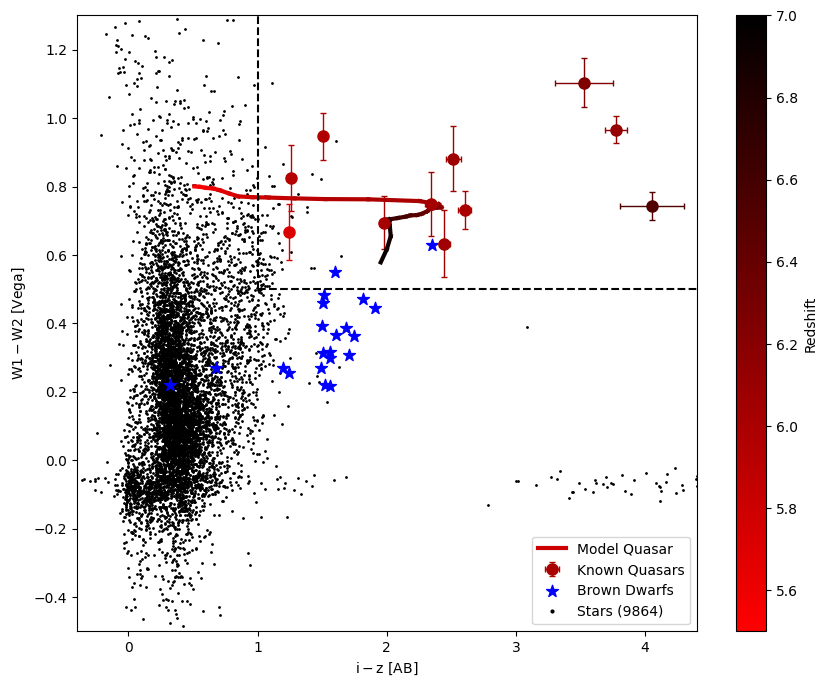

In [321]:
fg, ax = plt.subplots(figsize=(10,8))

# Plotting stars from DES tiles
star_sc = ax.scatter(
    tile_stars['i-z'], tile_stars['W1-W2'],
    c='k', s=1
)

# Plotting dwarfs
dwf_sc = ax.scatter(
    dwarfs_df['i-z'], dwarfs_df['W1-W2'],
    marker='*',c='b',s=80,
    label='Brown Dwarfs'
)

# Plotting known HZQs
def redshift_colour(z):
    "Colours a shade of red between z=5.5 and z=7.0"
    return np.array([1-(z-5.5)/1.5, 0,0,1])

for i, row in hzq_df.iterrows():
    col = redshift_colour(row['redshift'])
    hzq_eb = ax.errorbar(
        row['i-z'], row['W1-W2_vg'],
        xerr=row['i-z_err'], yerr=row['W1-W2_err'],
        fmt='o', mfc=col, mec=col, ms=8,
        elinewidth=1, ecolor=col, capsize=2.5,
        label='Known Quasars'
    )

# Adding QSO tracks
blur=15 # Samples every {blur} points
for ((i, row1), (j,row2)) in zip(
    qso_track[::blur][:-1].iterrows(),
    qso_track[::blur][1:].iterrows(),
):
    ax.plot(
        [row1['i-z'], row2['i-z']],
        [row1['W1-W2'], row2['W1-W2']],
        c=redshift_colour(row1['redshift']),
        lw=3
    )

# Colorbar
redshift_colors = np.zeros((256,4))
redshift_colors[:,3] = 1.
redshift_colors[:,0] = np.linspace(1.,0.,256)
redshift_cmap = colors.ListedColormap(redshift_colors)
cbar = fg.colorbar(
    cm.ScalarMappable(
        norm=colors.Normalize(vmin=5.5, vmax=7.),
        cmap=redshift_cmap
    ), ax=ax
)
cbar.ax.set_ylabel('Redshift')

# Selection lines
ax.vlines(1., .5, 1.3, colors='k', linestyles='dashed')
ax.hlines(.5, 1., 4.4, colors='k', linestyles='dashed')

ax.set_xlabel(r'$\mathrm{i}-\mathrm{z}$ [AB]')
ax.set_ylabel(r'$\mathrm{W1}-\mathrm{W2}$ [Vega]')
ax.set_xlim(-.4,4.4)
ax.set_ylim(-.5,1.3)
# Legend
legend_elements = [
    lines.Line2D([0],[0], c=[.8,0,0,1], lw=3, label='Model Quasar'),
    hzq_eb,
    dwf_sc,
    lines.Line2D([0],[0],c='k',lw=0,marker='o',ms=2, label=f'Stars ({len(tile_stars)})')
]
ax.legend(handles=legend_elements, loc='lower right')

## Clustering Space

In [322]:
fl = np.load('../data/processed/embedding.npz')
ids = fl['ids'].astype(int)
embedding = fl['embedding']

hzq_df = pd.read_csv('../data/external/known_hzqs.csv')
is_hzq = np.array(
    [coi in hzq_df['COADD_OBJECT_ID'].values
    for coi in ids]
).astype(int)
hzq_arch = [1621863463, 1695974542] # Archival quasars
is_hzq[ids==hzq_arch[0]]=2
is_hzq[ids==hzq_arch[1]]=2

cut_df = pd.read_csv('../data/processed/cut_crossmatched_objects.csv', index_col=0)
cut_df = cut_df.loc[ids]

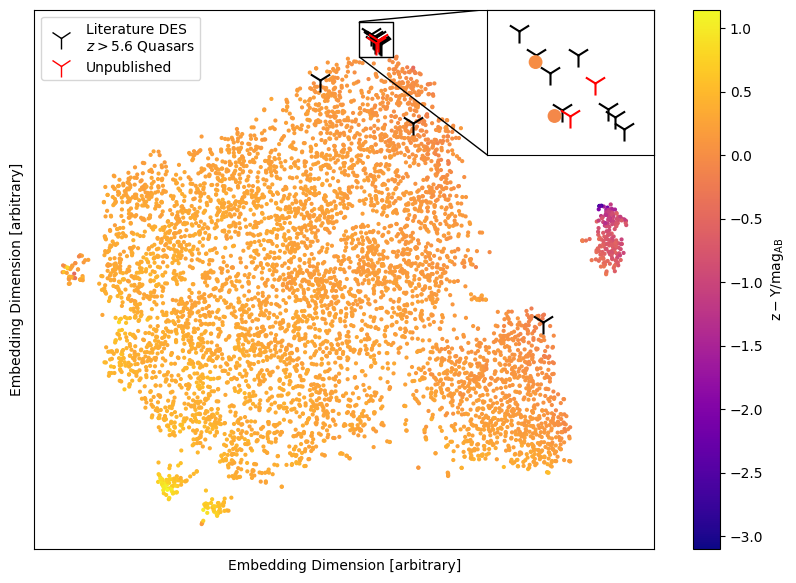

In [367]:
fg, ax = plt.subplots(figsize=(10,7))
qm='1'

insax = ax.inset_axes([.73,.73,.27,.27])
ax.scatter(
    embedding[is_hzq==0,0], embedding[is_hzq==0,1],
    c=(cut_df['z_mag']-cut_df['Y_mag'])[is_hzq==0],
    cmap=cm.plasma, s=4
)
for s, axis in zip([4,20],[ax, insax]):
    axis.scatter(
        embedding[is_hzq==1,0], embedding[is_hzq==1,1],
        s=300, marker=qm, c='k'
    )
    axis.scatter(
        embedding[is_hzq==2,0], embedding[is_hzq==2,1],
        s=300, marker=qm, c='r'
    )
    axis.set_xticks([])
    axis.set_yticks([])
sc = insax.scatter(
    embedding[is_hzq==0,0], embedding[is_hzq==0,1],
    c=(cut_df['z_mag']-cut_df['Y_mag'])[is_hzq==0],
    cmap=cm.plasma, s=80
)

# Box
(x0,x1,y0,y1)=(7.5,15,45,52)
xlims=ax.get_xlim()
ylims=ax.get_ylim()
ax.plot([x0,x1,x1,x0,x0],[y1,y1,y0,y0,y1],'k',lw=1)
ax.plot([x0+.2,36],[y1,ylims[1]],'k',lw=1)
ax.plot([x0+.2,36],[y0,26],'k',lw=1)
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# Colorbar
cbar = fg.colorbar(sc, ax=ax)
cbar.set_label(r'$\mathrm{z}-\mathrm{Y / mag}_{\mathrm{AB}}$')

ax.set_xlabel('Embedding Dimension [arbitrary]')
ax.set_ylabel('Embedding Dimension [arbitrary]')

insax.set_xlim(x0+2, x1-2)
insax.set_ylim(y0+2, y1-2)

# Legend
custom_lines = [
    lines.Line2D([0],[0], marker=qm,ms=16, color='k',lw=0),
    lines.Line2D([0],[0], marker=qm,ms=16, color='r',lw=0)
]
ax.legend(
    custom_lines,
    [r"""Literature DES
$z>5.6$ Quasars""",
    r'Unpublished'],
    loc='upper left'
)